# Face Filter

By Joshua Franklin and Tiffany Phan.<br>
Created for the CSCI 4622 - Machine Learning final project.

In [1]:
import os
import io
import json
import requests
import numpy as np
import matplotlib.pyplot as plt

from typing import Tuple
from PIL import Image
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout

Using TensorFlow backend.


### Problem Description

Face filter solves the problem that many social media companies face: detecting faces in an image and applying a filter
to them. Facebook, Snapchat, TikTok, and many more companies use this technology to make applying filters to images much
easier, without requiring their users to manually tell the software where their face is. We wanted to create our own
version of this for our final project in order to learn how it is done.

This project is completed in two parts. First, this notebook serves as a detailed description of our project, our EDA
procedure, model analysis, and also contains code for generating, training, and saving the final model we chose to work
with. The other part of our project is a Python script that repeatedly takes an image from a web camera, uses the model
generated by this notebook to detect your face, applies a "bulge" filter to it, and displays the result to the user.
This can be found in the main.py file.

This is a supervised learning problem since we are providing the model with labels during training.

### Exploratory Data Analysis

We started our project using a dataset from Kaggle located here:
https://www.kaggle.com/drgilermo/face-images-with-marked-landmark-points. This dataset looked very promising at first
since it seemed to provide many facial landmarks we could work with in order to make our filter respond uniquely to
different shapes of faces. However, after a discussion about the scope of our project, we determined that would be too
hard to fit in the time frame of this project, and decided that simply detecting the center of the face and applying the
filter there would be good enough. This dataset would still work though, as our first attempt was to use only the nose
tip data from this dataset, which gave a good approximation of the center of the face. Unfortunately, after attempting
to train models on this dataset, we realized the dataset would not allow our model to be general enough since almost all
samples in the dataset are zoomed in on someone's face. If we expected our users to put their face right up to the
camera anyway, there would be no reason to detect faces in the first place. From here we realized we needed to look for
a better dataset that did not only contain zoomed in images.

After some research, we came across this dataset: https://www.kaggle.com/dataturks/face-detection-in-images. This
dataset seemed great because it contained people's faces in many different situations, not just when the camera is
zoomed in on someone's face. The label data was a bounding box around each face, which is less information than the
previous dataset offered, but by averaging together each corner of the box, we were still able to determine the center
of the face, which is fine enough for our project. The only problem with this dataset is that it is rather small. After
removing the samples that were of no use to our project, we were left with only 145 data points. When we tried to train
a model on this dataset, we ended up with either a model that was not accurate enough for our project, or a model that
was over fit to the training data. Either way, we needed more data.

The solution we came up with was to generate some of our own data. We did this by taking many pictures of ourselves and
the family we were with in front of a variety of backgrounds, lighting conditions, and facial expressions. We then
labeled each point in the generated data with the center of the face. In order to aid this process, we created a tool
inside the main.py file for generating data easily. To start this tool, run `python main.py --mode datagen`, and click
on the center of your face to create a data point. After closing the program, the results are saved to a file. Writing
this tool allowed us to generate hundreds of data points in a relatively short amount of time. With the data from the
dataset combine with our generated data, we were able to create a very general model with a high accuracy.

Before clean the data, lets download the data first. The dataset is committed to this repository for your convenience,
but the images are simply URLs that must be fetched. Once they are fetched once, they are stored in a file so they do
not need to be fetched again.

In [2]:
CACHED_DATA_PATH = 'cached_data'
full_cached_data_path = '{}.npy'.format(CACHED_DATA_PATH)

def fetch_image(url: str) -> np.ndarray:
    """ Fetch and image from a url and convert it to a numpy array.

    The return value's shape is (width, height, number of channels). If the image is a JPG, there will be three
    channels (RGBA). If the image is a PNG, there will be four channels (RGBA).
    """

    return np.asarray(Image.open(io.BytesIO(requests.get(url).content)))

# Load in the dataset.
with open('data.json') as file:
    raw_data = json.load(file)

# Filter out all images with more than one person. The reason for this is explained in the markdown cell below.
raw_data = filter(lambda point: len(point['annotation']) == 1, raw_data)

# Only download the images if they are not already downloaded.
if os.path.exists(full_cached_data_path):
    print('Images have already been downloaded. Loading from cache...')
    raw_face_data = np.load(full_cached_data_path)
else:
    print('Images not found, downloading now...')
    raw_face_data = np.array([fetch_image(point['content']) for point in raw_data])
    np.save(CACHED_DATA_PATH, raw_face_data)

Images have already been downloaded. Loading from cache...


Now it is time to clean the data. This involves removing the information that is useless for this project, as well as
structuring each image in a standard shape so that every image has the same resolution, aspect ratio, color channels,
etc.

The dataset from the internet was a series of images that were either JPGs or PNGs. These are all converted into numpy
arrays in the function defined above. Each array returned by the function has a dimension for the image's width, a
dimension for the image's height, and a dimension for the image's color channels. JPGs have three color channels (RGB)
while PNGs have four color channels (RGBA). The labels come right from the json file in this repository, which contains
a list of "annotations" for each image, each storing two x values and two y values representing the bounding box around
a face. If there are multiple annotations for an image, it means that there are more than one face present in the image.

For the scope of our project, we do not feel the need to support multiple faces in an image, so the first step to
cleaning the data is to remove all images with multiple faces. This step is actually done on the
`raw_data = filter(lambda point: len(point['annotation']) == 1, raw_data)` line above, since removing these images
before they are downloaded saves a lot of time while downloading the images, and also reduces the image cache size.

The next step in cleaning the data is to convert the bounding box data into point data the represents the center of the
face. We did this by averaging together the two x points and the two y points as shown below.

In [3]:
raw_point_data = np.array([[
    np.mean([
        point['annotation'][0]['points'][0]['x'],
        point['annotation'][0]['points'][1]['x'],
    ]),
    np.mean([
        point['annotation'][0]['points'][0]['y'],
        point['annotation'][0]['points'][1]['y'],
    ])
] for point in raw_data])

The point data is still not ready to be used yet though, since it is currently represented by percentages of the whole
image. For example, if an image had a width of 500 pixels and the x coordinate of the face center was at 100 pixels, it
would be represented in the data set as 0.2, or 20% of the way through the image. The helper function `center_in_pixels`
defined below will help translate these percentages into pixels, and the `show_face` function below it will allow us to
see what one of the images in the dataset looks like, and will also draw a red dot on the face center.

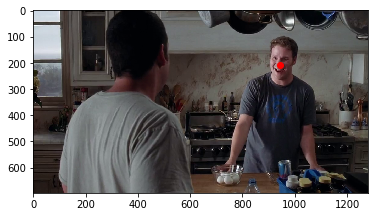

In [4]:
def center_in_pixels(face: np.ndarray, point: np.ndarray) -> np.ndarray:
    """ Helper function for converting a point in percentage to a point in pixels. """

    return np.array([[point[0] * face.shape[1]], [point[1] * face.shape[0]]])

def show_face(face: np.ndarray, point: np.ndarray):
    """ Helper function to show a face a draw a red dot at the center. """

    plt.imshow(face, cmap='gray')
    plt.scatter(*point, c='red')

demo_index = 0
show_face(raw_face_data[demo_index], center_in_pixels(raw_face_data[demo_index], raw_point_data[demo_index]))

We now have all the data represented in a way that is easy to work with, but it is still not in a format a machine
learning model can understand. In order to convert each image into this format, we need to standardize each image's
resolution, aspect ratio, color channels, and more.

We decided that each image should be represented by a 120x120 black and white image, which implies a 1:1 aspect ratio.
We also decided that each color should be represented by a value between 0 and 1 so it is easier for the model to
understand, where as right now it is an integer between 0 and 255.

The function `process_face` below does all this, and the function `process_faces` below that applies the `process_face`
function to a list of faces and points.

In [5]:
IMAGE_SIZE = 120

def process_face(face: np.ndarray, point: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    # Delete the alpha channel if one exists.
    if face.shape[2] == 4:
        face = np.delete(face, np.s_[3], 2)

    # Average all the other channels together to create a black and white image.
    face = np.mean(face, 2)

    # Convert box coordinates to pixels.
    pixel_box = center_in_pixels(face, point)

    # Make the image a square.
    if face.shape[0] > face.shape[1]:
        face = np.pad(face, ((0, 0), (0, face.shape[0] - face.shape[1])), 'constant')
    else:
        face = np.pad(face, ((0, face.shape[1] - face.shape[0]), (0, 0)), 'constant')

    # Resize to a more reasonable size.
    pixel_box = np.array([
        int(pixel_box[0] * (IMAGE_SIZE / face.shape[1])),
        int(pixel_box[1] * (IMAGE_SIZE / face.shape[0])),
    ])
    face = np.array(Image.fromarray(face).resize((IMAGE_SIZE, IMAGE_SIZE))) / 255

    return face, pixel_box

def process_faces(faces: np.ndarray, points: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    processed_faces = []
    processed_points = []
    for face, point in zip(faces, points):
        processed_face, processed_point = process_face(face, point)
        processed_faces.append(processed_face)
        processed_points.append(processed_point)

    return np.array(processed_faces), np.array(processed_points)

We can now call the function on the face and point data, and view the same image as before to see the difference.

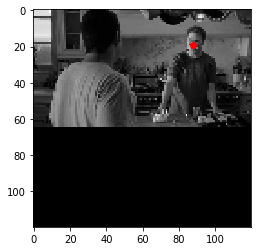

In [6]:
generated_data_added = False
face_data, point_data = process_faces(raw_face_data, raw_point_data)
show_face(face_data[demo_index], point_data[demo_index])

Now that the data is cleaned, we can explore it even more. For example, lets see where all of the face center points are
located by plotting all of them in a scatter plot.

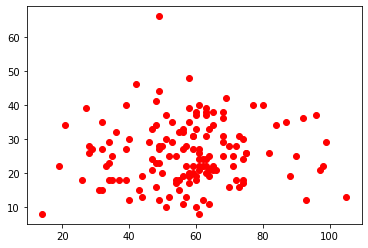

In [7]:
def show_scatter():
    plt.scatter(
        [point[0] for point in point_data],
        [point[1] for point in point_data],
        c='red',
    )

show_scatter()

The first thing we notice is that many of the data points are clumped in the center, which is not good for our project
because it is not always the case that the users's face will be in the exact center of the screen. Before we even
started training our model, this was our first hint that we will eventually need more data.

Next, we add our generated data that was generated by the `main.py` script running in datagen mode. No cleaning is
required since the data generated by the script is already in the desired format. The code below loads in each generated
dataset and concatenates it with the current data.

**Note**: We have not committed these files to the repository because we felt it was too personal and did not want it
          public on the internet.

In [8]:
def add_dataset(faces_path: str, points_path: str):
    global face_data, point_data

    face_data = np.concatenate((face_data, np.load(faces_path)))
    point_data = np.concatenate((point_data, np.load(points_path)))

if generated_data_added:
    print('Generated data has already been added to the dataset. Skipping...')
else:
    add_dataset('generated_data/josh_room_faces.npy', 'generated_data/josh_room_points.npy')
    add_dataset('generated_data/josh_kitchen_faces.npy', 'generated_data/josh_kitchen_points.npy')
    add_dataset('generated_data/josh_bathroom_faces.npy', 'generated_data/josh_bathroom_points.npy')
    add_dataset('generated_data/tiffany_room_faces.npy', 'generated_data/tiffany_room_points.npy')
    add_dataset('generated_data/david_living_room_faces.npy', 'generated_data/david_living_room_points.npy')

generated_data_added = True

We can now see what the last data point in the dataset looks like, which happens to be of my father.

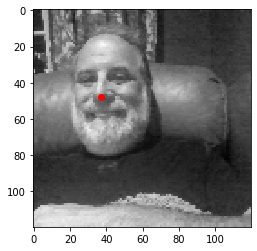

In [9]:
show_face(face_data[-1], point_data[-1])

We can also now see the same scatter plot as above, but with the added data, which now looks much more spread out.

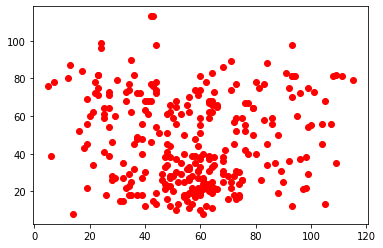

In [10]:
show_scatter()

### Model Analysis

Since the input to our project is image data, it makes the most sense to use a convolutional neural network. This choice
was immediately justified when we tried our first, simple CNN model, which yielded surprisingly accurate results, with
an accuracy score of 96% after only 20 epochs.

This simple CNN model uses just two convolutional layers, each relu activation (since relu usually works well for CNNs).
Following each convolutional layer is a max pooling layer and batch normalization, which are both standard for CNNs.
This is then followed by a flatten layer, which is needed since our output is 1-dimensional, and a final dense layer so
we can view the output. Lastly, we used the adam optimizer since this is also a great optimizer for CNNs in general, and
mean square error as a loss function since this our output is simply a point on a 2-dimensional grid.

To test the model, the final cell in this notebook saves the current model to a file, which is read by the main.py
script. We can test how well the model works by plugging it directly into our project's frontend and seeing how it
performs.

In [11]:
model = Sequential([
    # Note: Even though there only one color channel, Keras still requires the input to be 3 dimensional.
    Conv2D(32, (3, 3), activation='relu', input_shape=(120, 120, 1)),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Flatten(),

    Dense(2, activation='relu'),
])

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(face_data.reshape((len(face_data), IMAGE_SIZE, IMAGE_SIZE, 1)), point_data, epochs=20)

Epoch 1/20
297/297 [==============================] - 2s 8ms/step - loss: 1481.8669 - accuracy: 0.7273
Epoch 2/20
297/297 [==============================] - 2s 7ms/step - loss: 729.3690 - accuracy: 0.8215

However, the model above severely over fit due to the small amount of convolutional layers, dense layers, and lack of
dropout layers. Our second model fixed these issues by adding more convolutional layers, an additional dense layer, and
a dropout layer. All other parts of the model including activation functions, optimizers, and loss function is the same.
We trained this model for 50 epochs instead of 20 like the model above because we were not as worried about over
fitting.

Although it is hard to document, we also tuned certain hyperparameters during this step like the amount of filters and
the kernel size in each convolutional layer, the pool size in each max pooling layer, and the amount of units in the
second to last dense layer. We finally decided on the following values since they gave us the best performance after
some trial and error.

In [12]:
model = Sequential([
    # Note: Even though there only one color channel, Keras still requires the input to be 3 dimensional.
    Conv2D(32, (3, 3), activation='relu', input_shape=(120, 120, 1)),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Flatten(),

    Dropout(0.25),
    Dense(64, activation='relu'),
    Dense(2, activation='relu'),
])

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(face_data.reshape((len(face_data), IMAGE_SIZE, IMAGE_SIZE, 1)), point_data, epochs=50)

Epoch 1/50
297/297 [==============================] - 3s 11ms/step - loss: 2262.1456 - accuracy: 0.6936
Epoch 2/50
297/297 [==============================] - 3s 9ms/step - loss: 562.5192 - accuracy: 0.7879

This model maintained a good accuracy score while not over fitting as much, so we decided to use it as our final model.

The code below saves the model to a file so it can be read by the main.py file.

In [13]:
model.save('model.h5')
print('Model saved to {}/model.h5.'.format(os.getcwd()))

Model saved to /home/josh/Desktop/MLProject/model.h5.


### Conclusion

Face Filter was created to detect faces in images and apply a filter to them, and our code in this notebook combined
with the code in main.py does exactly that. Our project started by downloading, cleaning up and reformatting the data,
which included writing a tool for generating our own data to support it. We then tried many different convolutional
neural networks and tuned their hyperparameters to see what worked and what didn't work. The model we eventually landed
on is properly tuned to be accurate while still not over fitting.

We learned a lot during this project. There was a lot of image manipulation involved, which required learning many numpy
functions for manipulating arrays of raw image data. Additionally, we probably went through more iterations of our
convolutional neural network than any homework or kaggle competition, which really taught us what effects each
hyperparameter has on the model's overall performance. Armed with this knowledge, we feel like we could create a CNN for
just about anything now.

There are many improvements we could have made to our project if we had more time. First off, while our model worked
well overall, it still has much room for improvement. We still have a relatively large margin of error, at least
compared to big companies like Facebook, Snapchat, or TikTok. Having more data would probably fix this, as the 300
samples we ended with is still not much for a convolutional neural network. Additionally, we could improve our project
by adding support for multiple faces, which would not be too hard considering our original dataset is already set up for
multiple faces. Lastly, we could improve our frontend by adding more filters, allowing users to take pictures and save
them (outside of datagen mode), and even make this a mobile app like Snapchat.